In [1]:
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

import numpy as np
import nbodykit
from nbodykit.lab import BigFileCatalog, HaloCatalog, cosmology, FFTPower
import matplotlib.pyplot as plt


# Implement HOD

## `Nbodykit` interface:

### Default Zheng+07:

In [2]:
cosmo = cosmology.Planck15
from nbodykit.hod import Zheng07Model

pig_file = '/home/qezlou/HD1/simulations/Goku/PIG_016'
cat = BigFileCatalog(pig_file, dataset='FOFGroups')
redshift = 1/cat.attrs['Time'] - 1
cat['Mass'] *= 1e10
halos = HaloCatalog(cat, 
                    cosmo=cosmo, 
                    redshift=redshift,
                    mdef='vir',
                    mass='Mass',
                    position='MassCenterPosition',
                    velocity='MassCenterVelocity')

halotools_halos = halos.to_halotools()
hod = halos.populate(Zheng07Model, alpha=0.5, sigma_logM=0.40, seed=42)
#hod = HODCatalog(halotools_halos)

In [5]:

print("total number of HOD galaxies = ", hod.csize)
print(hod.columns)

print("number of centrals = ", hod.compute((hod['gal_type']==0).sum()))
print("number of satellites = ", hod.compute((hod['gal_type']==1).sum()))

total number of HOD galaxies =  289236
['Position', 'Selection', 'Value', 'Velocity', 'VelocityOffset', 'Weight', 'conc_NFWmodel', 'gal_type', 'halo_hostid', 'halo_id', 'halo_mvir', 'halo_num_centrals', 'halo_num_satellites', 'halo_rvir', 'halo_upid', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_x', 'halo_y', 'halo_z', 'host_centric_distance', 'vx', 'vy', 'vz', 'x', 'y', 'z']
number of centrals =  244921
number of satellites =  44315


In [3]:
cen_idx = hod['gal_type'] == 0
sat_idx = hod['gal_type'] == 1

cens = hod[cen_idx]
sats = hod[sat_idx]

In [4]:
gal_power = FFTPower(hod, mode='1d', Nmesh=512)
cen_power = FFTPower(cens, mode='1d', Nmesh=512)
sat_power = FFTPower(sats, mode='1d', Nmesh=512)
cen_sat_power = FFTPower(cens, second=sats, mode='1d', Nmesh=512)
# z-space pwoer
LOS = [0, 0, 1]
hod['RSDPosition'] = hod['Position'] + hod['VelocityOffset'] * LOS
mesh = hod.to_mesh(position='RSDPosition', Nmesh=512, compensated=True)
rsd_gal_power = FFTPower(mesh, mode='1d').run()[0]

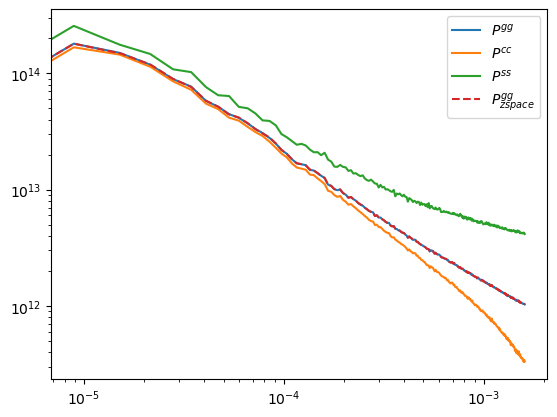

In [6]:
# plot galaxy auto power, centrals auto power, and sats auto power
fig, ax= plt.subplots(1,1)
labels = [r"$P^{gg}$", r"$P^{cc}$", r"$P^{ss}$"]
for i, r in enumerate([gal_power, cen_power, sat_power]):
    Pk = r.power
    ax.loglog(Pk['k'], Pk['power'].real-Pk.attrs['shotnoise'], label=labels[i])

ax.loglog(rsd_gal_power['k'], rsd_gal_power['power']-rsd_gal_power.attrs['shotnoise'], label=r'$P^{gg}_{zspace}$', ls='--')
ax.legend()
#fig.savefig('powers.png')

## Costum HOD model:

In [9]:
nbodykit.hod

<module 'nbodykit.hod' from '/home/qezlou/miniconda3/envs/het-cosmo/lib/python3.8/site-packages/nbodykit/hod.py'>

In [40]:
diff = (hod['RSDPosition'] / hod['Position'] - 1).compute()
print(np.min(diff), np.max(diff))
del diff


-0.2706028626358894 0.23365135970888828
